# A DFA Overview Video

If you'd like to relive my first lecture on DFA, be my guest; play the Youtube video below!
My own advice: listen a little and then stop the video and start playing with the code below!

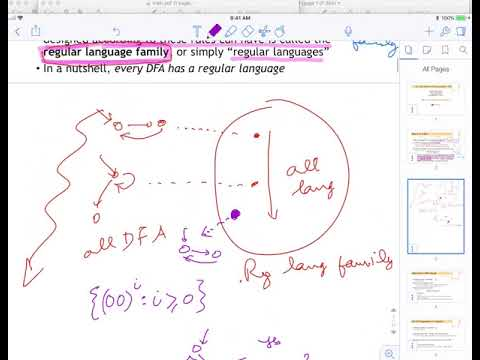

In [11]:
# This Youtube video walks through a basic DFA lecture
from IPython.display import YouTubeVideo
YouTubeVideo('FItN6CK1mow')

# Simple DFA Exercises

In [12]:
import sys
sys.path[0:0] = ['../..','../../3rdparty'] # Put these at the head of the search path
from jove.DotBashers import *
from jove.Def_md2mc  import *
from jove.Def_DFA    import *
from jove.LangDef    import *  # for testing DFA actions

# Try using a few help commands

In [13]:
help(md2mc)

Help on function md2mc in module jove.Def_md2mc:

md2mc(src='None', fname='None')
    md2mc converts a markdown source to a machine (mc).
    
    One can feed the markdown in three ways, shown via 
    pseudo-examples:
    
    1) md2mc()
    
       It means you will provide a file-name
       (you will be prompted for one). Then the markdown is read from
       that file. 
       
    2) md2mc(src="<any string S other than 'File'>")
    
       S is now taken as the markdown string and parsed. This is 
       bound to be a multi-line file. 
       
       There is a Jupyter bug that if the parser (or any process) 
       consuming a multi-line input throws an exception, you will get 
       a strange error message: 
       ERROR:root:An unexpected error occurred while tokenizing input
       Ignore it please, and instead spend your time fixing the 
       markdown input. See for details:
       https://github.com/ipython/ipython/issues/6864
       
       
    3) md2mc(src="File", f

In [14]:
help(intersect_dfa)

Help on function intersect_dfa in module jove.Def_DFA:

intersect_dfa(D1in, D2in)
    In : D1in (consistent DFA)
         D2in (consistent DFA)
    Out: DFA for language intersection of D1in, D2in (consistent DFA).



# Specify your DFA : now as a "raw" dict

This is error-prone. A better method will be introduced momentarily!

In [15]:
Fig34 = {
 'Q': {'A', 'F', 'I'},
 'Sigma': {'0', '1'},
 'Delta': {('A', '0'): 'I',
  ('A', '1'): 'I',
  ('F', '0'): 'I',
  ('F', '1'): 'I',
  ('I', '0'): 'A',
  ('I', '1'): 'F'},
 'q0': 'I',
 'F': {'F'}
}

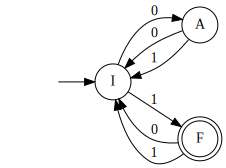

In [16]:
dotObj_dfa(Fig34)

# The same DFA in automd (Jove's markdown)

This is much less error-prone than a "plain old dict" that Fig34 above represented.

Notice that there is a mini compiler that processes this markdown language
and generates "code". The code is basically the dict defined as Fig34 above.

This mini-compiler would be studied in later chapters. In particular,
students will get to know:

* how we parse Fig34md below, and pick out "->" as a token

* how to collect state names

* how "I" will be recognized to be an initial-state name

* how "F" will be recognized to be a final state name

In general, anything that starts with "i" or "I" will be an initial state,
and anything that starts with "f" or "F" will be a final state. The parser
underlies function "md2mc" below. 

The parser will also do error-checking. Try renaming all the "I"
states below to, say, "j". Then the error message obtained will be this (after a huge gory Python error stack dump, you'll see this):

>> AssertionError: Error: DFA with 0 starting states is illegal.

Try keeping the "I" state name, but naming the state "A" to be "IA".
Then, the error message obtained will be:

>> AssertionError: Error: DFA with 2 starting states is illegal.

Studying this mini-compiler will be a treat, in that a student will
understand how lexing and parsing works "for real", how error-checks
are done, how comments are processed, and how the "code" is generated
if all is well.

It also generates well-documented DFA for the reader to study. Why not
teach good SW engineering practices even when developing a DFA? After
all, these DFA may go into airplanes to be critical controllers, and
we don't want them to be ill-documented.


In [17]:
Fig34md = '''  !! Comments begin with !! and last till the end of line
DFA            !! This keyword tells "md2mc" that it is parsing a DFA
I : 0     -> A !! DFA transition: From initial state I, upon 0, go to state A
A : 0 | 1 -> I !! Two DFA transitions: from A, upon 0 or a 1, go to state I
I : 1     -> F !! A DFA transition from I to F. I is the initial state and F is final 
F : 0 | 1 -> I !! From F upon 0 or a 1, go to I.
'''

In [18]:
DFA1 = md2mc('''DFA

I : 0   -> A
A : 0|1 -> I
I : 1   -> F
F : 0|1 -> I

''')

Generating LALR tables


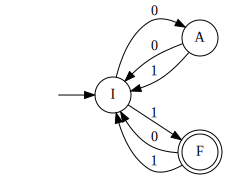

In [19]:
dotObj_dfa(DFA1)

In [20]:
step_dfa(DFA1, 'I', '0')

'A'

In [21]:
run_dfa(DFA1, '01100101')

'I'

In [22]:
run_dfa(DFA1, '011001011')

'F'

In [23]:
lstar

<function jove.LangDef.lstar(L, n)>

# Function md2mc is your automd compiler

In [24]:
Fig34MC = md2mc(Fig34md)
Fig34MC

{'Q': {'A', 'F', 'I'},
 'Sigma': {'0', '1'},
 'Delta': {('I', '0'): 'A',
  ('A', '0'): 'I',
  ('A', '1'): 'I',
  ('I', '1'): 'F',
  ('F', '0'): 'I',
  ('F', '1'): 'I'},
 'q0': 'I',
 'F': {'F'}}

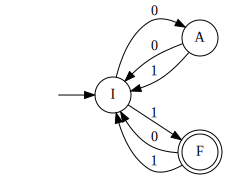

In [25]:
# md2mc alone produces a dict similar to Fig34, above.
# We pass it to dotObj_dfa which prints the DFA image,
# as shown below.

dotObj_dfa(md2mc(Fig34md))

In [26]:
accepts_dfa(md2mc(Fig34md), "10101")

True

# Testing acceptance in one "go"

Generating multiple strings according to the numeric order (increasing
lengths, with each length category exhausted before going to the next 
length category) is a handy test-input generator.

Plus, the "numeric order" is a powerful concept which we shall use 
when we later discuss the "dovetail enumeration" order (in Chapter 14
and beyond).


In [27]:
from math import floor, log, pow
def nthnumeric(N, Sigma={'0','1'}):
    """Assume Sigma is a 2-sized list/set of chars (default {'a','b'}). 
       Produce the Nth string in numeric order, where N >= 0.
       Idea : Given N, get b = floor(log_2(N+1)) - need that 
       many places; what to fill in the places is the binary 
       code for N - (2^b - 1) with 0 as Sigma[0] and 1 as Sigma[1].    
    """
    if (type(Sigma)==set):
       S = list(Sigma)
    else:
       assert(type(Sigma)==list
       ), "Expected to be given set/list for arg2 of nthnumeric."
       S = Sigma
    assert(len(Sigma)==2
          ),"Expected to be given a Sigma of length 2."
    if(N==0):
        return ''
    else:
        width = floor(log(N+1, 2))
        tofill = int(N - pow(2, width) + 1)
        relevant_binstr = bin(tofill)[2::] # strip the 0b 
                                           # in the leading string
        len_to_makeup = width - len(relevant_binstr)
        return (S[0]*len_to_makeup + 
                shomo(relevant_binstr,
                      lambda x: S[1] if x=='1' else S[0]))

In [28]:
[ nthnumeric(i) for i in range(20) ]

['',
 '1',
 '0',
 '11',
 '10',
 '01',
 '00',
 '111',
 '110',
 '101',
 '100',
 '011',
 '010',
 '001',
 '000',
 '1111',
 '1110',
 '1101',
 '1100',
 '1011']

# Now one can write a test loop

We plow thru the first 20 numeric-order listed strings,
and test for acceptance.


In [29]:
for s in [ nthnumeric(i) for i in range(20) ]:
    if accepts_dfa(md2mc(Fig34md), s):
        print("Fig34md DFA accepts ", s)
    else:
        print("Fig34md DFA does not accept ", s)

Fig34md DFA does not accept  
Fig34md DFA accepts  1
Fig34md DFA does not accept  0
Fig34md DFA does not accept  11
Fig34md DFA does not accept  10
Fig34md DFA does not accept  01
Fig34md DFA does not accept  00
Fig34md DFA accepts  111
Fig34md DFA does not accept  110
Fig34md DFA accepts  101
Fig34md DFA does not accept  100
Fig34md DFA accepts  011
Fig34md DFA does not accept  010
Fig34md DFA accepts  001
Fig34md DFA does not accept  000
Fig34md DFA does not accept  1111
Fig34md DFA does not accept  1110
Fig34md DFA does not accept  1101
Fig34md DFA does not accept  1100
Fig34md DFA does not accept  1011


# Now, simply run the cells, use help

Run the cell contents. At any time if you have a doubt about
some function, say "foo", run the "help(foo)" command. Also
refer to Appendix B of our book for a complete explanation of
all the Jove functions.


In [30]:
Fig34MC = md2mc(Fig34md)
Fig34MC

{'Q': {'A', 'F', 'I'},
 'Sigma': {'0', '1'},
 'Delta': {('I', '0'): 'A',
  ('A', '0'): 'I',
  ('A', '1'): 'I',
  ('I', '1'): 'F',
  ('F', '0'): 'I',
  ('F', '1'): 'I'},
 'q0': 'I',
 'F': {'F'}}

In [31]:
is_partially_consistent_dfa(Fig34MC)

True

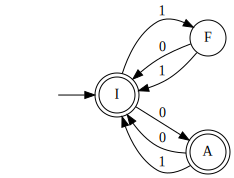

In [32]:
dotObj_dfa_w_bh(comp_dfa(Fig34MC))

In [33]:
ev0 = md2mc('''
DFA
IF : 0 -> A
A  : 0 -> IF
''')

In [34]:
ev0

{'Q': {'A', 'IF'},
 'Sigma': {'0'},
 'Delta': {('IF', '0'): 'A', ('A', '0'): 'IF'},
 'q0': 'IF',
 'F': {'IF'}}

In [35]:
dev0 = dotObj_dfa(ev0)

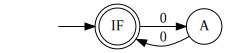

In [36]:
dev0

# You can generate PDF out of a DFA

This is one way to "print" a DFA as PDF. There are 
a few more such commands tucked away within Jupyter.


In [37]:
# Generate a PDF this way
dev0.render('dev0')

'dev0.pdf'

# Poke a DFA, add to its Sigma

You can expand the Sigma of a DFA later on. Then
if you totalize the DFA, you will see black-hole
states emerging. The newly added symbols lead to
the Black hole states, as shown below.


In [38]:
ev0_bh =  addtosigma_dfa(ev0, set({'1'}))

In [39]:
ev0_bh

{'Q': {'A', 'IF'},
 'Sigma': {'0', '1'},
 'Delta': {('IF', '0'): 'A', ('A', '0'): 'IF'},
 'q0': 'IF',
 'F': {'IF'}}

In [40]:
ev0_bh_totalize = totalize_dfa(ev0_bh)

In [41]:
ev0_bh

{'Q': {'A', 'IF'},
 'Sigma': {'0', '1'},
 'Delta': {('IF', '0'): 'A', ('A', '0'): 'IF'},
 'q0': 'IF',
 'F': {'IF'}}

In [42]:
do_ev0_tot = dotObj_dfa_w_bh(ev0_bh_totalize)

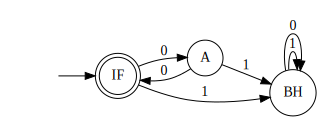

In [43]:
do_ev0_tot

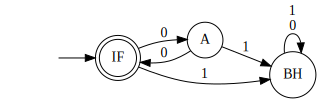

In [44]:
dotObj_dfa_w_bh(ev0_bh_totalize, FuseEdges=True)

<span style="color:blue"> **We can now write routines to print DFA using dot. The main routines are listed below.** </span>

* dot_dfa_w_bh : lists all states of a DFA including black-hole states
* dot_dfa      : lists all isNotBH states (see below for a defn), i.e. suppress black-holes
     - Usually there are too many transitions to them and that clutters the view
     

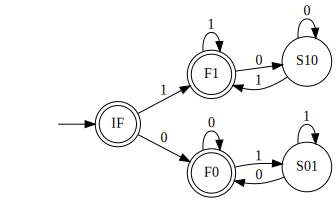

In [45]:
dfaBESame = md2mc('''
DFA !! Begins and ends with same; epsilon allowed
IF  : 0 -> F0
IF  : 1 -> F1
!!
F0  : 0 -> F0
F0  : 1 -> S01
S01 : 1 -> S01
S01 : 0 -> F0
!!
F1  : 1 -> F1
F1  : 0 -> S10
S10 : 0 -> S10
S10 : 1 -> F1
''')
DOdfaBESame = dotObj_dfa(dfaBESame)
DOdfaBESame

## Let us now administer some tests to print dot-strings generated.

We will demonstrate two ways to print automata: 

1. First generate a dot string via dot_dfa or dot_dfa_w_bh
   (calling the result "dot_string") 
   1. Then use the srcObj = Source(dot_string) call
   2. Thereafter we can display the srcObj object directly into the browser
   3. Or, one can also later convert the dot_string to svg or PDF
2. OR, one can directly generate a dot object via the dotObj_dfa or dotObj_dfa_w_bh call
   (calling the result "dot_object")
   1. Then directly display the dot_object
   2. There are conversions available for dot_object to other formats too

# One can read DFAs from files

In [46]:
dped1 = md2mc(src="File", fname="pedagogical1.dfa")
#machines/dfafiles/pedagogical1.dfa

In [47]:
dped1

{'Q': {'A', 'B', 'F', 'IF'},
 'Sigma': {'0', '1'},
 'Delta': {('IF', '0'): 'A',
  ('IF', '1'): 'B',
  ('A', '0'): 'B',
  ('A', '1'): 'B',
  ('B', '1'): 'F',
  ('B', '0'): 'IF',
  ('F', '0'): 'B',
  ('F', '1'): 'B'},
 'q0': 'IF',
 'F': {'F', 'IF'}}

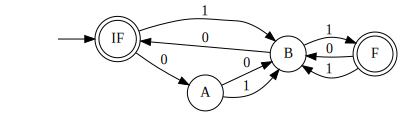

In [48]:
dotObj_dfa(dped1)

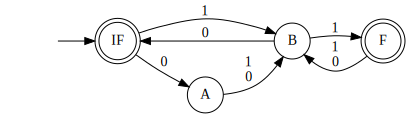

In [49]:
dotObj_dfa(dped1, FuseEdges=True)

In [50]:
ends0101 = md2mc(src="File", fname="endsin0101.dfa")

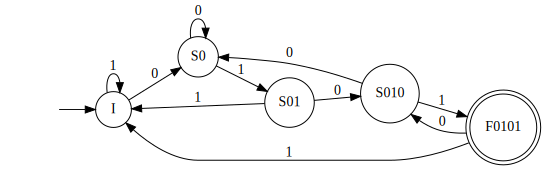

In [51]:
dotObj_dfa(ends0101)

In [52]:
thirdlastis1=md2mc(src="File", fname="thirdlastis1.dfa")
#machines/dfafiles/thirdlastis1.dfa

In [53]:
thirdlastis1

{'Q': {'F100',
  'F101',
  'F110',
  'F111',
  'I',
  'S0',
  'S00',
  'S000',
  'S001',
  'S01',
  'S010',
  'S011',
  'S1',
  'S10',
  'S11'},
 'Sigma': {'0', '1'},
 'Delta': {('I', '0'): 'S0',
  ('I', '1'): 'S1',
  ('S0', '0'): 'S00',
  ('S0', '1'): 'S01',
  ('S1', '0'): 'S10',
  ('S1', '1'): 'S11',
  ('S00', '0'): 'S000',
  ('S00', '1'): 'S001',
  ('S01', '0'): 'S010',
  ('S01', '1'): 'S011',
  ('S10', '0'): 'F100',
  ('S10', '1'): 'F101',
  ('S11', '0'): 'F110',
  ('S11', '1'): 'F111',
  ('S000', '0'): 'S000',
  ('S000', '1'): 'S001',
  ('S001', '0'): 'S010',
  ('S001', '1'): 'S011',
  ('S010', '0'): 'F100',
  ('S010', '1'): 'F101',
  ('S011', '0'): 'F110',
  ('S011', '1'): 'F111',
  ('F100', '0'): 'S000',
  ('F100', '1'): 'S001',
  ('F101', '0'): 'S010',
  ('F101', '1'): 'S011',
  ('F110', '0'): 'F100',
  ('F110', '1'): 'F101',
  ('F111', '0'): 'F110',
  ('F111', '1'): 'F111'},
 'q0': 'I',
 'F': {'F100', 'F101', 'F110', 'F111'}}

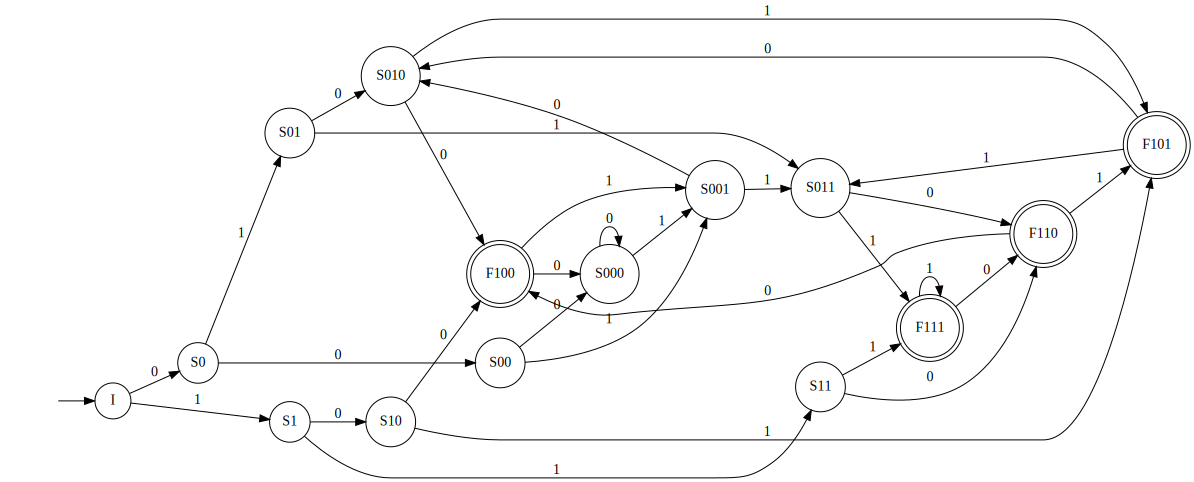

In [54]:
dotObj_dfa(thirdlastis1)

In [55]:
dped1=md2mc(src="File", fname="pedagogical2.dfa")
#machines/dfafiles/pedagogical2.dfa

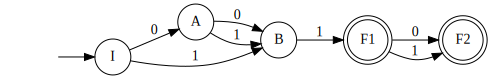

In [56]:
dotObj_dfa(dped1)

In [57]:
secondLastIs1 = md2mc('''
!!------------------------------------------------------------
!! This DFA looks for patterns of the form ....1.
!! i.e., the second-last (counting from the end-point) is a 1
!!
!! DFAs find such patterns "very stressful to handle",
!! as they are kept guessing of the form  'are we there yet?'
!! 'are we seeing the second-last' ?
!! They must keep all the failure options at hand. Even after
!! a 'fleeting glimpse' of the second-last, more inputs can
!! come barreling-in to make that "lucky 1" a non-second-last.
!!
!! We take 7 states in the DFA solution.
!!------------------------------------------------------------

DFA
!!------------------------------------------------------------
!! State : in ->  tostate !! comment
!!------------------------------------------------------------

I   :  0 ->  S0  !! Enter at init state I
I   :  1 ->  S1  !! Record bit seen in state letter
                     !! i.e., S0 means "state after seeing a 0"
			 
S0  :  0 ->  S00 !! continue recording input seen
S0  :  1 ->  S01 !! in state-letter. This is a problem-specific
                 !! way of compressing the input seen so far.

S1  :  0 ->  F10 !! We now have a "second last" available!
S1  :  1 ->  F11 !! Both F10 and F10 are "F" (final)

S00 :  0 ->  S00 !! History of things seen is still 00
S00 :  1 ->  S01 !! Remember 01 in the state

S01 :  0 ->  F10 !! We again have a second-last of 1
S01 :  1 ->  F11 !! We are in F11 because of 11 being last seen

F10 :  0 ->  S00 !! The second-last 1 gets pushed-out
F10 :  1 ->  S01 !! The second-last 1 gets pushed-out here too

F11 :  0 ->  F10 !! Still we have a second-last 1
F11 :  1 ->  F11 !! Stay in F11, as last two seen are 11

!!------------------------------------------------------------
''')

In [58]:
nthnumeric(20,['0','1'])

'0101'

In [59]:
run_dfa(secondLastIs1, '0101')

'S01'

In [60]:
accepts_dfa(secondLastIs1, '0101')

False

In [61]:
tests = [ nthnumeric(i, ['0','1']) for i in range(12) ]
for t in tests:
    if accepts_dfa(secondLastIs1, t):
        print("This DFA accepts ", t)
    else:
        print("This DFA rejects ", t)

This DFA rejects  
This DFA rejects  0
This DFA rejects  1
This DFA rejects  00
This DFA rejects  01
This DFA accepts  10
This DFA accepts  11
This DFA rejects  000
This DFA rejects  001
This DFA accepts  010
This DFA accepts  011
This DFA rejects  100


In [62]:
help(run_dfa)

Help on function run_dfa in module jove.Def_DFA:

run_dfa(D, s)
    In : D (consistent DFA)
         s (string over D's sigma, including "")
    Out: next state of D["q0"] via string s



# Study DeMorgan's Law on DFA

This is an extensive illustration of union, intersection and complementation, DFA minimization, isomorphism test, language equivalence test, and an application of DeMorgan's law

## Define a DFA for "odd 1s" (over {0,1})

In [63]:
dfaOdd1s = md2mc('''
DFA
I : 0 -> I
I : 1 -> F
F : 0 -> F 
F : 1 -> I
''')

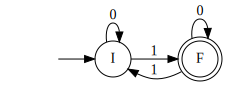

In [64]:
dotObj_dfa(dfaOdd1s)

## Define a DFA for "ends in 0101"

In [65]:
ends0101 = md2mc('''
DFA 
I     : 0 -> S0  
I     : 1 -> I 
S0    : 0 -> S0 
S0    : 1 -> S01 
S01   : 0 -> S010 
S01   : 1 -> I 
S010  : 0 -> S0 
S010  : 1 -> F0101 
F0101 : 0 -> S010 
F0101 : 1 -> I 
''')

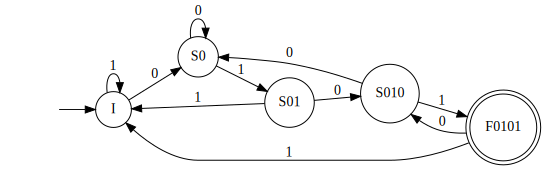

In [66]:
dotObj_dfa(ends0101)

## Now produce a DFA for the union

Union of "odd 1s" and "ends in 0101"


In [67]:
odd1sORends0101 = union_dfa(dfaOdd1s,ends0101)

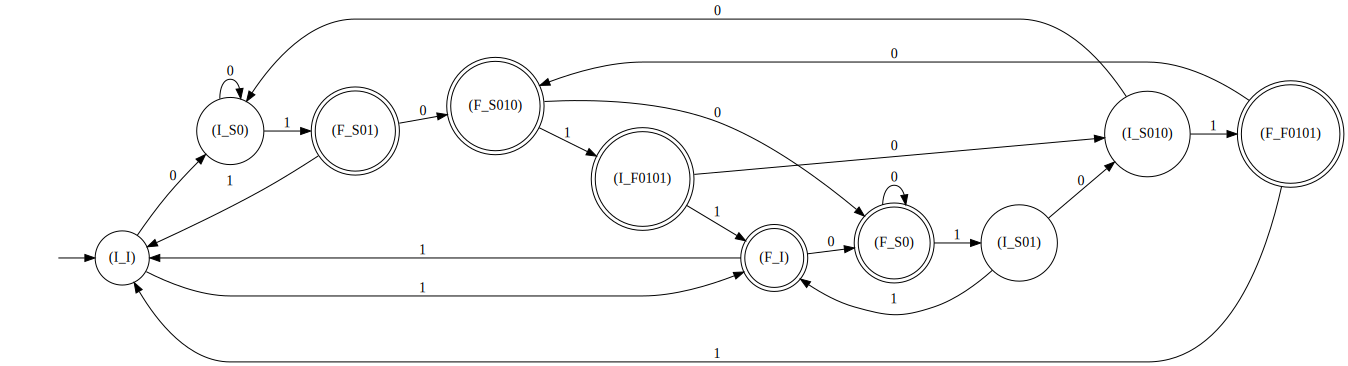

In [68]:
dotObj_dfa(odd1sORends0101)

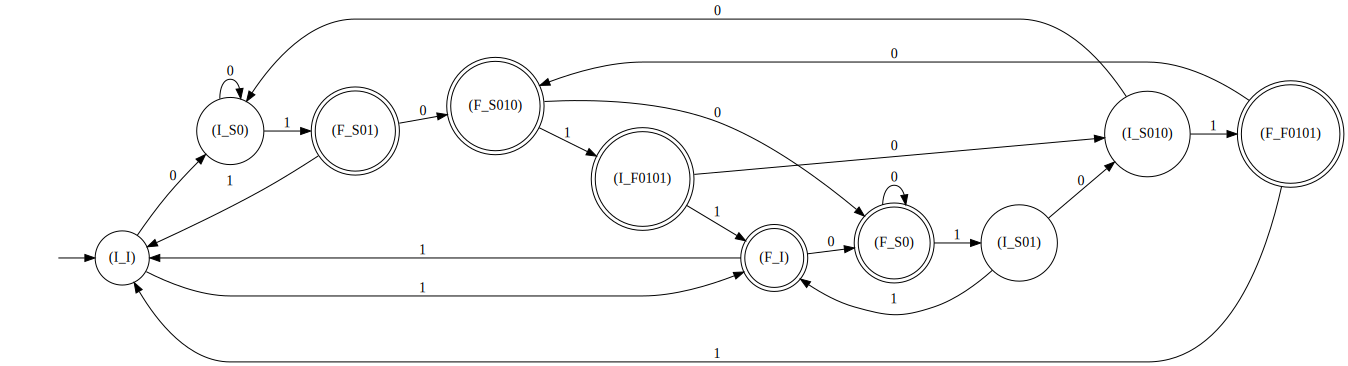

In [69]:
dotObj_dfa(odd1sORends0101)

## Apply DFA minimization

In [70]:
Minodd1sORends0101 = min_dfa(odd1sORends0101)

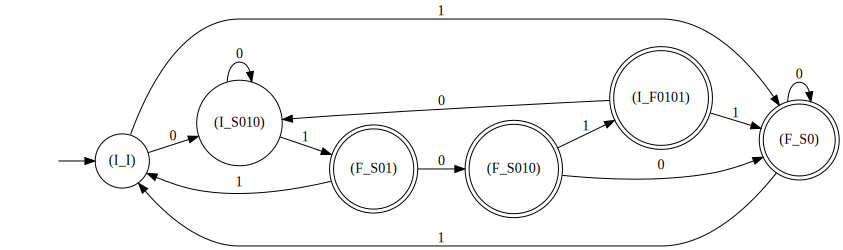

In [71]:
dotObj_dfa(Minodd1sORends0101)

## Minimization vs. Isomorphism vs. Lang. Eql.

After minimization, we may not have isomorphic DFA, but we 
will have language-equivalent DFA

In [72]:
iso_dfa(odd1sORends0101, Minodd1sORends0101)

False

In [73]:
langeq_dfa(odd1sORends0101, Minodd1sORends0101)

True

## Now define "odd 1s" AND "ends in 0101"

Define the and of these machines and minimize it

In [74]:
odd1sANDends0101 = intersect_dfa(dfaOdd1s,ends0101)

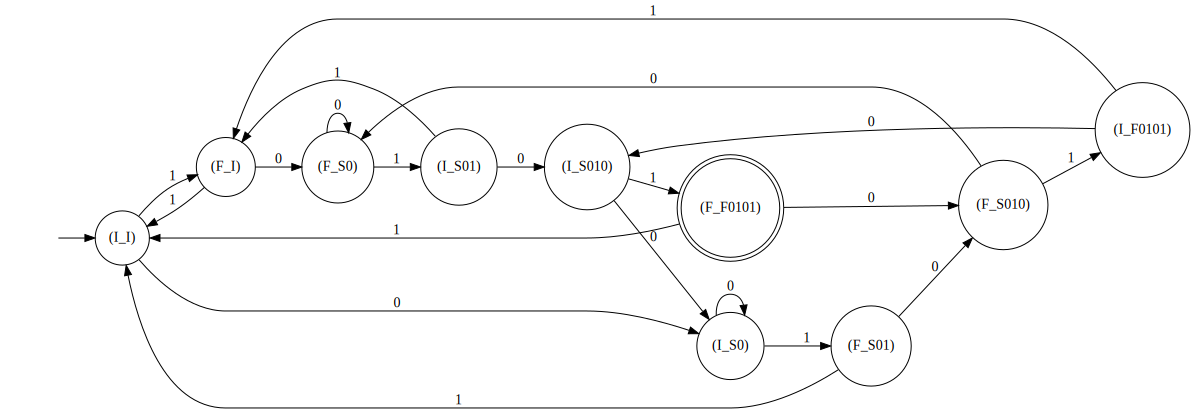

In [75]:
dotObj_dfa(odd1sANDends0101)

In [76]:
Minodd1sANDends0101 = min_dfa(odd1sANDends0101)

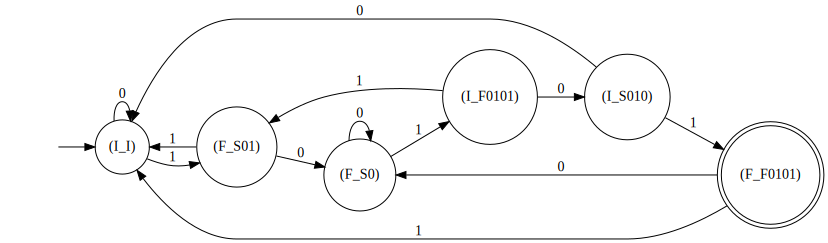

In [77]:
dotObj_dfa(Minodd1sANDends0101)

## Now, complement the individual machines

In [78]:
CdfaOdd1s = comp_dfa(dfaOdd1s)

In [79]:
Cends0101 = comp_dfa(ends0101)

## Complement of the union of the complements

The complement of the union of the complements of M1 and M2 is of course the intersection of M1 and M2! Let us check that!


In [80]:
C_CdfaOdd1sORCends0101 = comp_dfa(union_dfa(CdfaOdd1s, Cends0101))

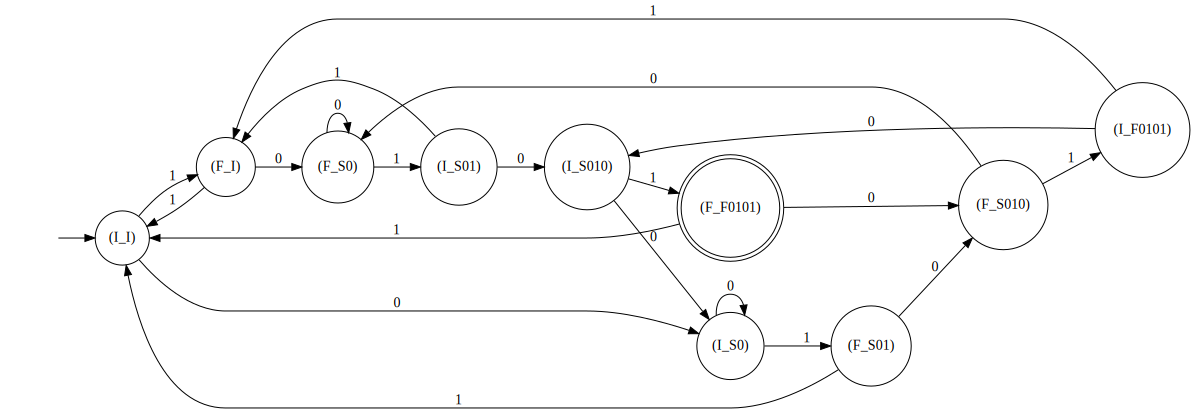

In [81]:
dotObj_dfa(C_CdfaOdd1sORCends0101)

In [82]:
MinC_CdfaOdd1sORCends0101 = min_dfa(C_CdfaOdd1sORCends0101)

## Minimized Comp(CdfaOdd1s OR Cends0101)

This will now pass the isomorphism check, below


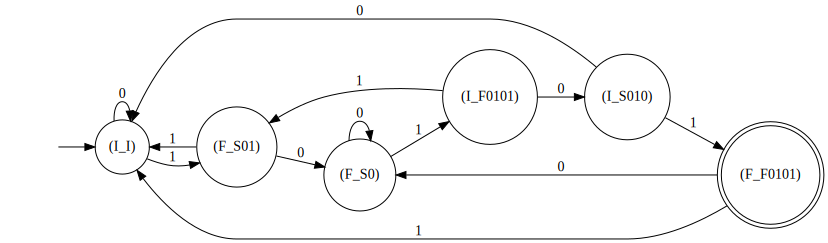

In [83]:
dotObj_dfa(MinC_CdfaOdd1sORCends0101)

## DeMorgan's Law works

The same machine, when obtained through two routes, turn out to be isomorphic when minimized


In [84]:
iso_dfa(MinC_CdfaOdd1sORCends0101, Minodd1sANDends0101)

True

# These are some examples from the book

In [85]:
blimp = md2mc('''
DFA 
I1 : a -> F2
I1 : b -> F3
F2 : a -> S8
F2 : b -> S5
F3 : a -> S7
F3 : b -> S4
S4 : a | b -> F6
S5 : a | b -> F6
F6 : a | b -> F6
S7 : a | b -> F6
S8 : a -> F6
S8 : b -> F9
F9 : a -> F9
F9 : b -> F6
''')

In [86]:
dblimp = dotObj_dfa(blimp)

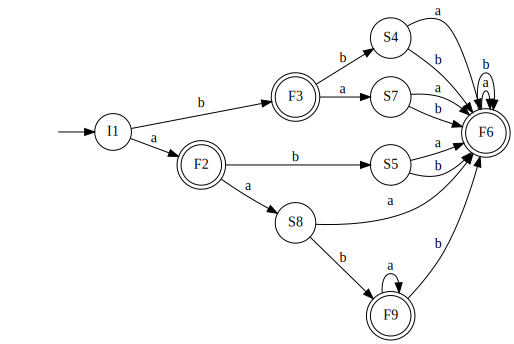

In [87]:
dblimp

In [88]:
dblimp = dotObj_dfa(blimp, FuseEdges=True)

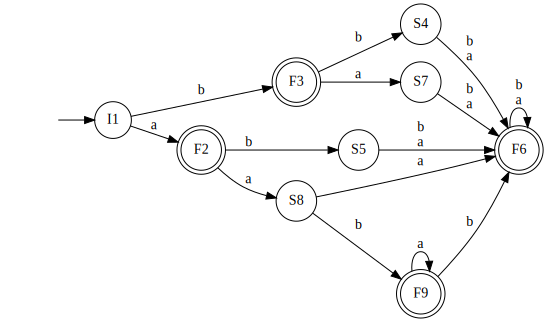

In [89]:
dblimp

In [90]:
mblimp = min_dfa(blimp)

In [91]:
dmblimp = dotObj_dfa(mblimp)

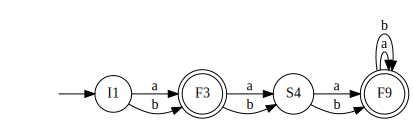

In [92]:
dmblimp

# Minimized "blimp" machine

The minimized blimp machine is indeed quite small.
